# 1. Introduction

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Background</b></p>
</div>

Welcome to this competition on predicting **Cervical Spine Fractures** from **Computed Tomography (CT) scans**. The **motivation** to use AI for this task is that a **quick** diagnosis can **reduce** the chance of **neurologic deterioration** and paralysis after trauma.

<center>
<img src="https://www.holisticbodyworks.com.au/wp-content/uploads/2018/05/Thoracic-Spine.jpg" width=400>
</center>

**Dataset origin**

The dataset we are using is made up of roughly **3000 CT studies**, [from twelve locations and across six continents](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/overview/acknowledgements). Spine **radiology specialists** have provided **annotations** to indicate the presence, vertebral level and location of any cervical spine fractures.

Special thanks to the competition **hosts** for providing such a comprehensive dataset:
* *Radiological Society of North America (RSNA)*
* *American Society of Neuroradiology (ASNR)*
* *American Society of Spine Radiology (ASSR)*

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.2 Evaluation metric</b></p>
</div>

We need to predict the **probability of fracture** for each of the **seven cervical vertebrae** denoted by C1, C2, C3, C4, C5, C6 and C7 as well as an **overall probability** of any fractures in the cervical spine. This means there will be **8 rows per image id**. Note that fractures in the skull base, thoracic spine, ribs, and clavicles are **ignored**.
    
The **competition metric** is a **weighted multi-label logarithmic loss** (average across all rows)
    
$$
L_{ij} = - w_j \left(y_{ij} \log(p_{ij}) + (1-y_{ij}) \log(1-p_{ij})  \right)
$$

where the **weights** [are given by](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392)
    
$$
w_{j} = \begin{cases}
1, \qquad \text{if vertebrae negative} \\
2, \qquad \text{if vertebrae positive} \\
7, \qquad \text{if patient negative} \\
14, \qquad \text{if patient negative}
\end{cases}
$$

<br>
<center>
<img src="https://i.postimg.cc/wBYCYqFG/metric-plot.png" width=600>
</center>
<br>

Notice how **more weight** is put on **positive cases** and and the **most weight** on the **overall probability** of any fractures.

<hr>

**Example:**

Below is a table going through an example of **how the evaluation metric is calculated** for a single case id. This would then be **averaged** across all row id's.

<center>
<img src="https://i.postimg.cc/nh2zCP5T/61415.jpg" width=750>
</center>

Note: it is convention to use the **natural logarithm** (base e) for calculating the log loss. 

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.3 Code requirements</b></p>
</div>

This is a **code competition**, which means that **submissions** are made through **notebooks**. Furthermore, the submission notebook is subject to these conditions:

* **run-time** (CPU/GPU) **<= 9 hours**
* **internet** access **disabled**
* **external data is allowed**, including pre-trained models
* the submission file must be named **submission.csv**
              
Note that the **test set is hidden**, and will populated when you submit your notebook. 

<hr>

*Competition timeline:*
    
* Start date - 28th July 2022
* Finish date - 27th October 2022

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.4 Libraries</b></p>
</div>

In [30]:
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install -U python-gdcm

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import os
from os import listdir
import re
import gc
import gdcm
import pydicom
from pydicom import dcmread
import pylibjpeg
from pydicom.pixel_data_handlers.util import apply_voi_lut
import scipy.ndimage
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings
import dask.array as da
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.6)

# 2. Data

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 Data frames</b></p>
</div>


In [32]:
# Load metadata
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
ss = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('sample shape:', ss.shape)
print('')

# Show first few entries
train_df.head()

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
sample shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


> **train.csv** - contains metadata for train_images.
> * StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
> * patient_overall - The patient level outcome, i.e. if any of the vertebrae are fractured.
> * C[1-7] - Whether the given vertebrae is fractured.

In [33]:
train_bbox.head()

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


> **train_bounding_boxes.csv** - contains bounding boxes of where fractures occured for a subset of the training set.
> * StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
> * x - x-coordinate of bounding box bottom left corner
> * y - y-coordinate of bounding box bottom left corner
> * width - width of bounding box
> * height - height of bounding box
> * slice_number - slice number of scan

Note: we only have bounding boxes for a [subset](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/343105) of the training set. We'll explore the exact proportion later on.

In [34]:
test_df.head()

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


> **test.csv** - contains metadata for test_images.
> * row_id - The row ID. This will match the same column in the sample submission file.
> * StudyInstanceUID - The study ID.
> * prediction_type - Which one of the eight target columns needs a prediction in this row.

Note: The full test set will be **populated at inference time**.

In [35]:
ss.head()

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


> **sample_submission.csv** - A valid sample submission.
> * row_id - The row ID. See the test.csv for what prediction needs to be filed in that row.
> * fracture - The target column.

# 3. EDA - METADATA
<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.1 Fracture distributions</b></p>
</div>

* The overall target is roughly **balanced** (52/48 split). 
* **C7** has the **highest proportion of fractures** (19%) whereas **C3** has the **lowest** (4%) which is concistent with https://www.sciencedirect.com/topics/medicine-and-dentistry/third-cervical-vertebra. 
* Several patients have **more than one** fracture.
* If **multiple fractures** occur on a single patient, they tend to occur in vertebrae **close together**, e.g. C4 & C5 as opposed to C1 & C7.

(0.0, 2800.0)

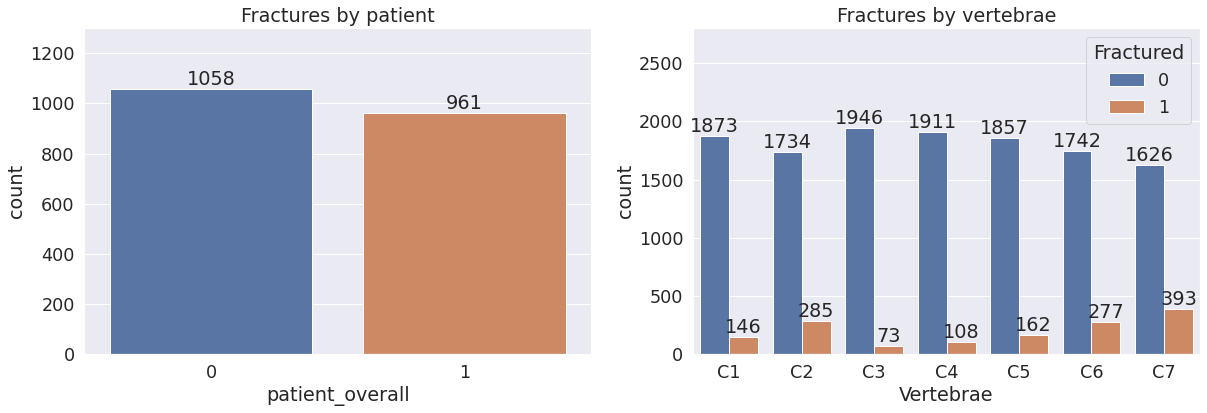

In [36]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])

(0.0, 1300.0)

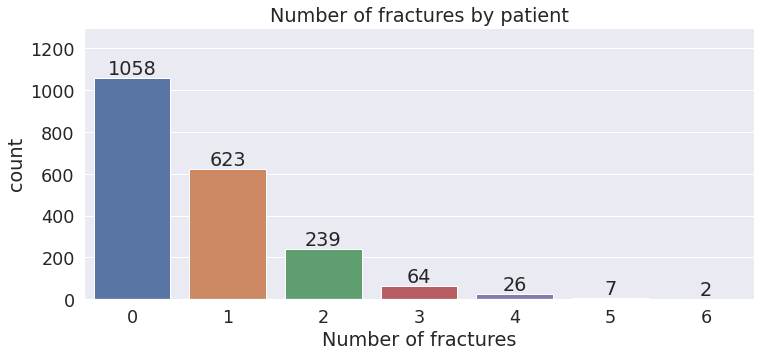

In [37]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')
plt.ylim([0,1300])

Text(0.5, 1.0, 'Correlations')

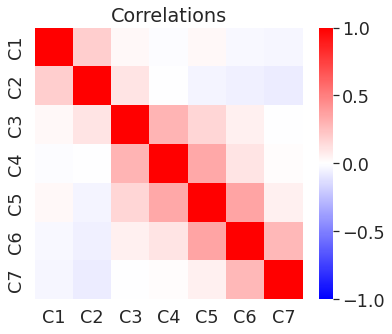

In [38]:
# Heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(train_df[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlations')

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.2 Study Id's</b></p>
</div>

The cases in the dataset have **unique id's** like '1.2.826.0.1.3680043.6200'. It turns out only the **number after the last full stop** is important. 

In [39]:
# Example
train_df['StudyInstanceUID'][0]

'1.2.826.0.1.3680043.6200'

In [40]:
# Find unique numbers in study id's
for i in range(7):
    print(train_df['StudyInstanceUID'].map(lambda x : x.split('.')[i]).unique())

['1']
['2']
['826']
['0']
['1']
['3680043']
['6200' '27262' '21561' ... '14341' '12053' '18786']


# 4. EDA - Train images

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 What is DICOM?</b></p>
</div>

A **.dcm** file follows the **Digital Imaging and Communications in Medicine** (DICOM) format. It is the standard format used for storing **medical images** and **related metadata**. It dates back to 1983, although it has been revised many times. 

This **pixel size/coarseness** of the scan **differs** from scan to scan (e.g. the distance between slices may differ), which can **hurt performance** of CNN approaches. We can deal with this by **isomorphic resampling**.

We can use the [pydicom library](https://pydicom.github.io/) to open and explore these files.

In [41]:
ex_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.12281/110.dcm"
dcm_example = pydicom.dcmread(ex_path)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.12281.1.110
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.12281.1.110
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '181303.847051'
(0010, 0010) Patient's Name                      PN: '12281'
(0010, 0020) Patient ID                          LO: '12281'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

>The **image data** is stored in an array under **'Pixel Data'**. Everything else is **metadata**.
>* The **'Rows'** and **'Columns'** values tell us the **image size**.
>* The **'Pixel Spacing'** and **'Slice Thickness'** tell us the **pixel size** and **thickness**. Together the form a **voxel**.
>* The **'Window Center'** and **'Window Width'** give information about the **brightness** and **contrast** of the image respectively.
>* The **'Rescale Intercept'** and **'Rescale Slope'** determine the range of pixel values. ([ref](https://stackoverflow.com/questions/10193971/rescale-slope-and-rescale-intercept)) and to tensform the pixel value into **HU(Hounsfield Unit)**.
>* **'ImagePositionPatient'** tells us the x, y, and z coordinates of the top left corner of each image in mm
>* **InstanceNumber** is the slice number.

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [42]:
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) # Sort the images based on the Z axis.
    return slices

In [43]:
path="../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.12281" #train_df.loc[0,'StudyInstanceUID']
patient=load_scan(path)

>### Adding further information

>1. The CT-scan captures information about the radiodensity of an object or tissue exposed to x-rays. A transversal slice of a scan is reconstructed after taking measurements from several different directions.
>2. We need to transform to Hounsfield units as the spectral composition of the x-rays depends on the measurement settings like acquisition parameters and tube voltage. By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable.
>3. A ct-scanner yields roughly 4000 grey values that can't be captured by our eyes. This is why windowing is performed. This way the image is displayed in a HU range that suites most to the region of interest. 

In [44]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    image = da.from_array(image)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    
    
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
        
    intercept = da.from_array([slices[slice_number].RescaleIntercept for slice_number in range(len(slices))])
    slope = da.from_array([slices[slice_number].RescaleSlope for slice_number in range(len(slices))])
    
    intercept=intercept.reshape((-1,1,1))
    slope=slope.reshape((-1,1,1))
    
    image= slope * image.astype("float64")
    image= image.astype("int16")
        
    image+= intercept
     
    return image.astype("int16")

In [45]:
patient_slice=get_pixels_hu(patient)

(-0.5, 511.5, 511.5, -0.5)

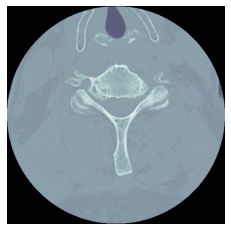

In [46]:
#Ploting pixel array
plt.imshow(patient[110].pixel_array,cmap='bone')
plt.axis("off")

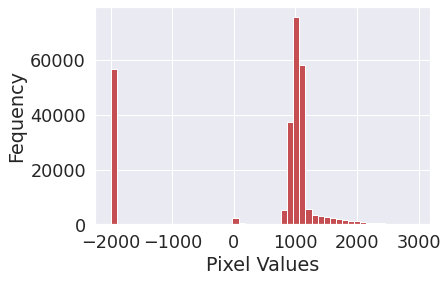

In [47]:
#Ploting pixel array distribution
plt.hist(patient[110].pixel_array.flatten(),color="r",bins=50)
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")
plt.show()

(-0.5, 511.5, 511.5, -0.5)

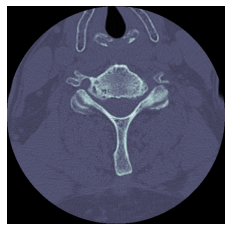

In [48]:
#Ploting HU array
plt.imshow(patient_slice[110],cmap='bone')
plt.axis("off")

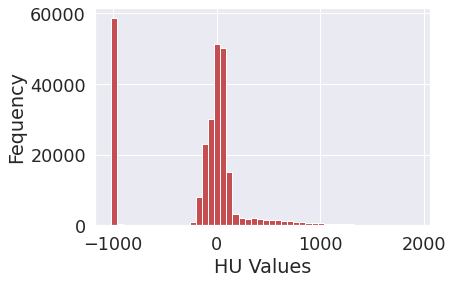

In [49]:
#Ploting HU distribution
plt.hist(patient_slice[110].flatten().compute(),color="r",bins=50)
plt.xlabel("HU Values")
plt.ylabel("Fequency")
plt.show()

<br>
<center>
    <h1>Reference <b>Hounsfield Unit (HU)</b> values for vertebral column</h1>
</center>
<br>

<br>
<center>
<img src="https://www.frontiersin.org/files/Articles/920167/fendo-13-920167-HTML/image_m/fendo-13-920167-t002.jpg" width=800>
</center>
<br>

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.3 Normalization</b></p>
</div>

As HU values range from **100** to **3000**. So we will use this values for normalization.

In [50]:
MIN_BOUND = 100
MAX_BOUND = 3000.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [51]:
image=normalize(patient_slice)

(-0.5, 511.5, 511.5, -0.5)

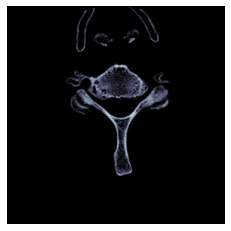

In [52]:
plt.imshow(image[110],cmap="bone")
plt.axis("off")

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.4 Zero centering</b></p>
</div>

As a final preprocessing step, it is advisory to **zero center** your data so that your **mean value is 0**. To do this you simply **subtract** the mean pixel value from all pixels.

In [53]:
PIXEL_MEAN = 0.016076984448095525

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [54]:
image=zero_center(image)

(-0.5, 511.5, 511.5, -0.5)

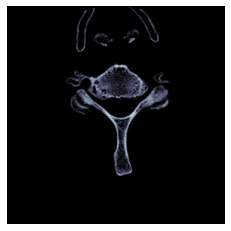

In [55]:
plt.imshow(image[110],cmap="bone")
plt.axis("off")

In [56]:
#Delete all unused objects to free up memory
del ax1
del ax2
del ax
del ex_path
del dcm_example
del path
del patient
del patient_slice
del image

gc.collect()

26273

In [57]:
#To preprocess all the patient folder and download it
def save_image():
    pixel_sum=0
    pixel_number=0
    for patient_ID in tqdm(train_df['StudyInstanceUID']):
        path="../input/rsna-2022-cervical-spine-fracture-detection/train_images/"+patient_ID
        patient_pixel=load_scan(path)
        patient_hu=get_pixels_hu(patient_pixel)
        patient_hu_normalised=normalize(patient_hu)
        patient_hu_normalised_centered=zero_center(patient_hu_normalised)
        
        del path
        del patient_pixel
        del patient_hu
        del patient_hu_normalised
        del patient_hu_normalised_centered
        gc.collect()

In [ ]:
save_image()

 16%|█▋        | 332/2019 [31:36<2:27:05,  5.23s/it]

This is great, but at the moment we don't know which vertebrae is being shown in each image. One way to work this out is by using the **segmentations**.

# 5. Segmentations

<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.1 What is NIfTI? </b></p>
</div>

A **.nii** file follows the **Neuroimaging Informatics Technology Initiative** (NIfTI) format. Compared to the DICOM, NIfTI is **simpler** and **easier** to support. 

To open .nii files we can use the [nibabel library](https://nipy.org/nibabel/gettingstarted.html).

In [ ]:
def load_NIfTI(path):
    nii_example = nib.load(path)

    # Convert to numpy array
    seg = nii_example.get_fdata()
    print(seg.shape)
    
    return seg

In [ ]:
path="../input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.12281.nii" #train_df.loc[0,'StudyInstanceUID']
segment_image=load_NIfTI(path)

Each nifti file contains segmentations for **all slices** in a scan. However, we need to be careful about the **orientation** of the segmentations.

> Please be aware that the NIFTI files consist of segmentation in the sagittal plane, while the DICOM files are in the axial plane.

The correct way to deal with this is explained in this [discussion post](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340612). We need to use the following line:

In [ ]:
# Align orientation with images
segment_image = segment_image[:, ::-1, ::-1].transpose(2, 1, 0)
segment_image.shape


<div style="color:white;display:fill;
            background-color:#e38e05;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.2 Exploring the masks</b></p>
</div>

In [ ]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: 1.2.826.0.1.3680043.12281', weight="bold", size=20)

for i in range(110,128):
    mask = segment_image[i]
    slice_no = i

    # Plot the image
    x = (i-110) // 6
    y = (i-110) % 6

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

Compare these with the previous images. These masks give us the **location** of the vertebrae, which is very helpful because we know the fractures can only occur in these regions.

They also tells us which **vertebrae** are in the images. By looking at the unique values in each slice, we find a 0 for the background and another number like 3 for vertebrae C3. 

In [ ]:
np.unique(segment_image[110])

Unfortunately, we don't have segmentations for the whole train set. This means we will have to extract the **vertebrae numbers** from the **.dcm files**. An idea to keep in mind is that maybe we could train a segmentation model to predict the segmentation masks for the rest of the train and all of the test images.